In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pickle
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy import signal
import nrrd
from PIL import Image

In [44]:
csv_path_stacks = "/work/jprieto/data/remote/EGower/hinashah_organized/Data/Field_Photos/Dec-2021_resampled/field_grades.csv"
output_dir = "/work/jprieto/data/remote/EGower/hinashah_organized/"
results_stacks_path = os.path.join(output_dir, 'Data/Field_Photos/Dec-2021_resampled.pickle')

In [45]:
df_stacks = pd.read_csv(csv_path_stacks)
df_stacks['class'] = (df_stacks['class'] >= 1).astype(int)
with open(results_stacks_path, 'rb') as f:
    results_stacks = pickle.load(f) #x, x_a, x_v, x_s, x_v_p
    

pred_np, x_a_np, x_v_np, x_s_np, x_v_p_np = results_stacks
pred_np = np.array(pred_np)
x_a_np = np.array(x_a_np)
x_v_np = np.array(x_v_np)
x_s_np = np.array(x_s_np)
x_v_p_np = np.array(x_v_p_np)
print(len(pred_np), len(df_stacks))

146 146


In [46]:
df_stacks["pred"] = np.argmax(pred_np, axis=1)
df_stacks

,img,class,pred
0,hinashah_organized/Data/Field_Photos/Dec-2021_...,0,0
1,hinashah_organized/Data/Field_Photos/Dec-2021_...,0,0
2,hinashah_organized/Data/Field_Photos/Dec-2021_...,0,0
3,hinashah_organized/Data/Field_Photos/Dec-2021_...,0,0
4,hinashah_organized/Data/Field_Photos/Dec-2021_...,0,0
...,...,...,...
141,hinashah_organized/Data/Field_Photos/Dec-2021_...,1,0
142,hinashah_organized/Data/Field_Photos/Dec-2021_...,1,0
143,hinashah_organized/Data/Field_Photos/Dec-2021_...,0,0
144,hinashah_organized/Data/Field_Photos/Dec-2021_...,1,1


[[69 11]
 [15 51]]
[[0.8625     0.1375    ]
 [0.22727273 0.77272727]]
              precision    recall  f1-score   support

           0       0.82      0.86      0.84        80
           1       0.82      0.77      0.80        66

    accuracy                           0.82       146
   macro avg       0.82      0.82      0.82       146
weighted avg       0.82      0.82      0.82       146



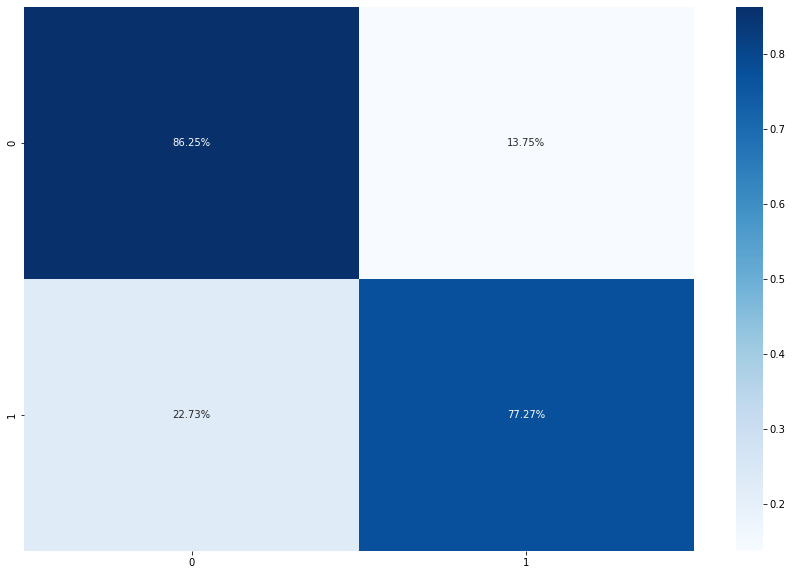

In [47]:
y_true_arr_stacks = [] 
y_pred_arr_stacks = []
for idx, row in df_stacks.iterrows():
  y_true_arr_stacks.append(row["class"])
  y_pred_arr_stacks.append(row["pred"])
    
cnf_matrix_stacks = confusion_matrix(y_true_arr_stacks, y_pred_arr_stacks)
print(cnf_matrix_stacks)
cnf_matrix_norm_stacks = cnf_matrix_stacks.astype('float') / cnf_matrix_stacks.sum(axis=1)[:, np.newaxis]
print(cnf_matrix_norm_stacks)
print(classification_report(y_true_arr_stacks, y_pred_arr_stacks))

plt.figure(figsize=[15,10])
sns.heatmap(cnf_matrix_norm_stacks, annot=True, fmt='.2%', cmap='Blues')
plt.show()

In [49]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_a_np)
df_stacks["pca_0"] = X_pca[:,0]
df_stacks["pca_1"] = X_pca[:,1]

In [50]:
fig = go.FigureWidget(make_subplots(rows=2, cols=2, column_widths=[0.7, 0.3], specs=[[{'colspan': 2}, {}],[{},{}]]))

fig.add_trace(go.Scatter(x=df_stacks["pca_0"], y=df_stacks["pca_1"], mode='markers', showlegend=False, marker=dict(
    color=df_stacks["class"], size=(df_stacks["pred"] + 1)*5, colorscale='sunset', showscale=True, opacity=1, line=dict(color='red', width=1)
)), row=1, col=1)
fig.add_trace(go.Scatter(mode='markers', showlegend=False, marker=dict(showscale=True, size=10, cmin=np.min(x_v_p_np), cmax=np.max(x_v_p_np), colorscale='sunset', line=dict(color='red', width=1))), row=2, col=1)
fig.add_trace(go.Scatter(mode='markers', marker=dict(color='LightSkyBlue', size=10), showlegend=False), row=2, col=1)
fig.add_trace(go.Image(), row=2, col=2)

fig.add_trace(go.Scatter(mode='markers', showlegend=False, marker=dict(showscale=False, size=10, cmin=np.min(x_v_p_np), cmax=np.max(x_v_p_np), colorscale='sunset', line=dict(color='magenta', width=2))), row=1, col=1)
fig.add_trace(go.Scatter(mode='markers', showlegend=False, marker=dict(showscale=False, size=10, cmin=np.min(x_v_p_np), cmax=np.max(x_v_p_np), colorscale='sunset', line=dict(color='magenta', width=2))), row=2, col=1)

fig.data[0].marker.showscale = True
fig.data[0].marker.colorbar.y = 0.8
fig.data[0].marker.colorbar.len = 0.5

fig.data[1].marker.showscale = True
fig.data[1].marker.colorbar.y = .2
fig.data[1].marker.colorbar.len = 0.5

fig.update_layout(
    autosize=False,
    width=1200,
    height=800
)

current_idx = {"idx": 0, "idx_f": 0, "img_np": []}

def update_study(trace, points, selector):
    if points.trace_name == 'trace 0' and len(points.point_inds) > 0:
        print("update_study", points)
        idx = points.point_inds[0]  
        x_feat_idx = np.array(x_v_np[idx]).reshape(-1, 256)
        x_feat_idx_pca = pca.transform(x_feat_idx)
        print(x_feat_idx_pca.shape)
#         scores_idx = np.array(scores[idx]).reshape(-1)
#         weights_idx = np.array(weights[idx]).reshape(-1)
        print(x_v_p_np.shape)
        df_idx = pd.DataFrame({
            "pca_0": x_feat_idx_pca[:,0],
            "pca_1": x_feat_idx_pca[:,1],
            "pred": np.array(np.argmax(x_v_p_np[idx], axis=1)).reshape(-1), 
            "score": np.array(x_s_np[idx]).reshape(-1)
#             ,
#             "scores": scores_idx,
#             "weights": weights_idx
            })

        with fig.batch_update():
            fig.data[1]['x'] = df_idx["pca_0"]
            fig.data[1]['y'] = df_idx["pca_1"]
            fig.data[1].marker.color = df_idx['pred']
            fig.data[1].text = ['s: {:f}, p: {:f}'.format(s, p) for s, p in zip(df_idx['score'], df_idx['pred'])]
#             fig.data[1].marker.cmin = np.max()
#             fig.data[1].marker.cmax = 1
            
            fig.data[2]['x'] = [df_stacks.loc[idx]["pca_0"]]
            fig.data[2]['y'] = [df_stacks.loc[idx]["pca_1"]]
              
            fig.data[4]['x'] = [df_stacks.loc[idx]["pca_0"]]
            fig.data[4]['y'] = [df_stacks.loc[idx]["pca_1"]]
            fig.data[4].marker.color = df_stacks.loc[idx]["class"]
            
            fig.update_layout(title=df_stacks.loc[idx]["img"])

            current_idx["idx"] = idx
            img_path = os.path.join("/work/jprieto/data/remote/EGower/", df_stacks.loc[idx]["img"]).replace("Dec-2021_resampled", "Dec-2021_resampled_stacks").replace(".jpg", ".nrrd")
            print(img_path)
            img_np, head = nrrd.read(img_path, index_order='C')
            
            print(head)
            current_idx["img_np"] = img_np
            current_idx["df_idx"] = df_idx
            
            print(os.path.basename(df_stacks.loc[idx]["img"]))
            
fig.data[0].on_click(update_study)

def update_img(trace, points, selector):
    if points.trace_name == 'trace 1' and len(points.point_inds) > 0:
        print('update_img', points)
        idx_f = points.point_inds[0] 
        current_idx["idx_f"] = idx_f
        
        with fig.batch_update():
#             fig.data[3]['z'] = current_idx["img_np"][idx_f]
            print(idx_f)
            fig.data[3]['z'] = np.flip(current_idx["img_np"][idx_f], axis=1)
        
            fig.data[5]['x'] = [current_idx["df_idx"].loc[idx_f]["pca_0"]]
            fig.data[5]['y'] = [current_idx["df_idx"].loc[idx_f]["pca_1"]]
            fig.data[5].marker.color = current_idx["df_idx"].loc[idx_f]["pred"]
    
fig.data[1].on_click(update_img)

fig

FigureWidget({
    'data': [{'marker': {'color': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, …